In [15]:
from pathlib import Path
import re
from xspec import AllData, AllModels, Xset, Plot
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
from src.utils import ChangeDir

from src.plot_settings import set_mpl
set_mpl()


GENERATING COMPPS MODEL PLOTS
Spectra directory: ../data/results/tau_kTe_study_radiative_transfer_20260218_180037/spectra
Energy range: 0.0001 10000 5000 log
  Found 15 .xcm files
  Grouped into 1 kTe values
/Users/mike/Repos/iki/compps_simulations
  Plotting kTe = 100 keV (15 tau values)
 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).
* * * * * * * * * * * * 

-1.5
4.48e-11
* * * * * * * * * * * * * * * * * * * * 
tau = -1.5
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996
Parameter delta values for fits will now be 0.01 * parValue
 Model systematic error set to 0

Model compPS<1> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   compPS     kTe        keV      100.000      +/-  0.0          
   2    1   compPS     EleIndex            2.00000      frozen
   3    1   compPS     Gmin          

array([4.47643327e-11, 2.77782219e-11, 2.13848798e-11, 1.62198996e-11,
       1.21399746e-11, 8.98402372e-12, 6.60538103e-12, 4.85755812e-12,
       3.60485264e-12, 2.72685042e-12, 2.12165506e-12, 1.70744412e-12,
       1.42218589e-12, 1.22166407e-12, 1.07626052e-12])

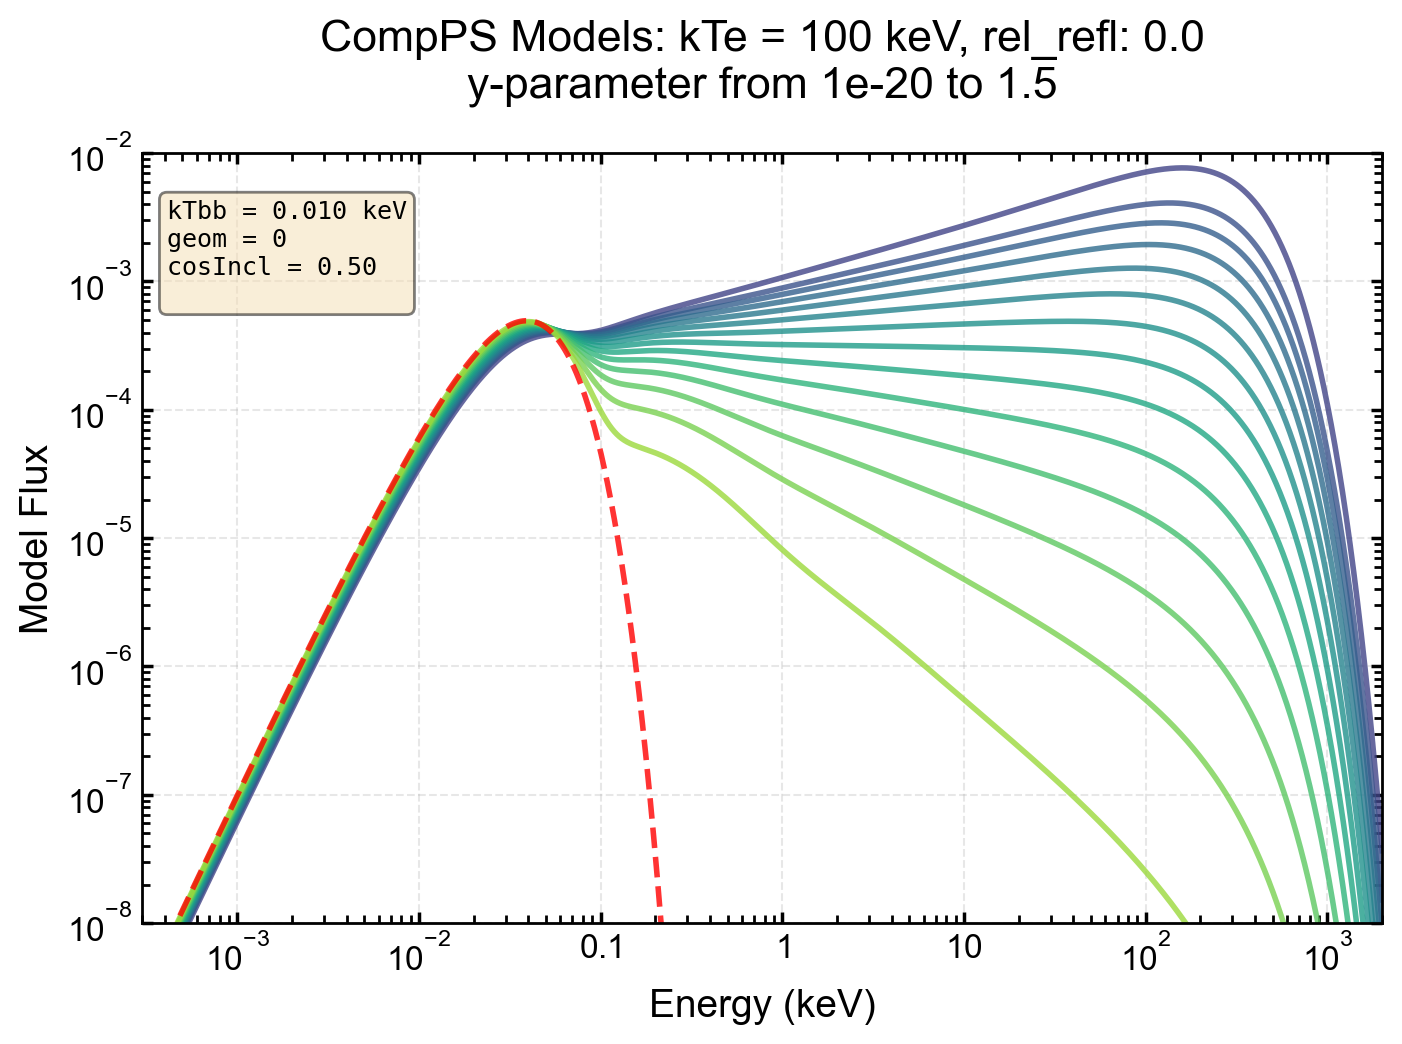

In [42]:
def plot_compps_models_by_kte(spectra_dir: str,
                              xspec_plt_en_range: str = "0.0001 10000 5000 log",
                              logger=True):
    """
    Plot CompPS model spectra from .xcm files, grouped by kTe value.

    For each kTe value, creates a single plot showing all tau values
    with visually distinguishable colors/linestyles.

    Parameters
    ----------
    spectra_dir : str
        Directory containing .xcm files (pattern: sim_grid_kTe{kTe}_tau{tau}_{timestamp}.xcm)
    output_dir : str
        Directory to save plots (will create plots/ subdirectory)
    xspec_plt_en_range : str
        Energy range string for XSPEC plotting (default: "0.1 50 1000 log")
    logger : logging.Logger, optional
        Logger instance for progress messages

    Returns
    -------
    list of str
        List of paths to saved plot files
    """

    def parse_tau_from_filename(tau_str: str) -> float:
        """
        Parse tau value from filename format back to float.

        Handles 'm' prefix for negative values.
        E.g., "m0.50" → -0.50, "0.50" → 0.50
        """
        if tau_str.startswith('m'):
            return -float(tau_str[1:])
        else:
            return float(tau_str)

    spectra_path = Path(spectra_dir).resolve()

    if logger:
        print("")
        print("=" * 70)
        print("GENERATING COMPPS MODEL PLOTS")
        print("=" * 70)
        print(f"Spectra directory: {spectra_dir}")
        print(f"Energy range: {xspec_plt_en_range}")

    # Find all .xcm files matching the pattern
    # Pattern: sim_grid_kTe{kTe:.0f}_tau{tau_str}_{timestamp}.xcm
    xcm_pattern = re.compile(r'sim_grid_kTe(\d+)_tau([\dm\d.]+)_\d{8}_\d{6}\.xcm')
    xcm_files = []

    for xcm_file in spectra_path.glob('sim_grid_kTe*.xcm'):
        match = xcm_pattern.match(xcm_file.name)
        if match:
            kTe_str = match.group(1)
            tau_str = match.group(2)
            try:
                kTe = float(kTe_str)
                tau = parse_tau_from_filename(tau_str)
                xcm_files.append((str(xcm_file), kTe, tau))
            except (ValueError, AttributeError) as e:
                if logger:
                    print(f"  Could not parse filename: {xcm_file.name} ({e})")
                continue

    if not xcm_files:
        if logger:
            print("  No matching .xcm files found")
        return []

    # Group files by kTe value
    files_by_kte: Dict[float, List[Tuple[str, float]]] = {}
    for xcm_file, kTe, tau in xcm_files:
        if kTe not in files_by_kte:
            files_by_kte[kTe] = []
        files_by_kte[kTe].append((xcm_file, tau))

    # Sort tau values for each kTe group
    for kTe in files_by_kte:
        files_by_kte[kTe].sort(key=lambda x: x[1])

    if logger:
        print(f"  Found {len(xcm_files)} .xcm files")
        print(f"  Grouped into {len(files_by_kte)} kTe values")

    # Use ChangeDir to ensure correct working directory for XSPEC
    # with ChangeDir(Path(__file__).parent.parent):
    print(Path.cwd().parent)
    with ChangeDir(Path.cwd().parent):
        for kTe in sorted(files_by_kte.keys()):
            tau_files = files_by_kte[kTe]

            if logger:
                print(f"  Plotting kTe = {kTe:.0f} keV ({len(tau_files)} tau values)")

            # Create figure
            _, ax = plt.subplots(figsize=(8, 5))

            # Use colormap for different tau values
            colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(tau_files)))

            fluxes = []
            taus = []

            for (xcm_file, tau), color in zip(tau_files, colors):
                try:
                    # Clear and restore XSPEC session
                    AllData.clear()
                    AllModels.clear()
                    Xset.restore(xcm_file)

                    # Set energy range and resolution for plotting
                    AllModels.setEnergies(xspec_plt_en_range)
                    AllModels.calcFlux('0.0001 10000.0')
                    flux = AllModels(1).flux[0]
                    fluxes.append(flux)
                    taus.append(tau)
                    print('* ' * 12 + '\n')
                    print(tau)
                    print(f'{flux:.2e}')

                    # Generate the plot data with model components
                    Plot("eemo")  # E: Energy, E: Energy, M: Model, O: (No data)

                    # Extract the energy grid and total model flux
                    en = list(map(float, Plot.x()))
                    total = list(map(float, Plot.model()))  # Total model

                    # Format tau label
                    # tau_label = f"y = {-tau:.2f}"

                    ls = '-'

                    if logger:
                        print("* " * 20)
                        print(f"tau = {tau}")

                    if tau == -0.0:
                        color = 'red'
                        ls = '--'

                    # Plot model
                    ax.plot(
                        en, total, alpha=0.8, color=color, lw=2, ls=ls #, label=tau_label
                        )

                except Exception as e:
                    if logger:
                        print(f"    Failed to plot {Path(xcm_file).name}: {e}")
                    continue

            # Extract model parameters from the first file (they should be the same for all)
            if tau_files:
                try:
                    if logger:
                        print("Extracting model parameters to place them on the plot...")

                    AllData.clear()
                    AllModels.clear()
                    Xset.restore(tau_files[0][0])  # Load first file to get parameters

                    model = AllModels(1)
                    compPS = model.compPS

                    # Extract key parameters
                    params = {
                        # 'kTe': compPS.kTe.values[0],
                        'kTbb': compPS.kTbb.values[0],
                        'geom': compPS.geom.values[0],
                        'cosIncl': compPS.cosIncl.values[0],
                        'rel_refl': compPS.rel_refl.values[0]  # Add this line
                    }

                    # Create parameter text
                    param_text = (
                        # f"kTe = {params['kTe']:.1f} keV\n"
                        f"kTbb = {params['kTbb']:.3f} keV\n"
                        f"geom = {params['geom']:.0f}\n"
                        f"cosIncl = {params['cosIncl']:.2f}\n"
                    )

                    # Add text box to plot
                    ax.text(0.02, 0.8, param_text,
                            transform=ax.transAxes,
                            fontsize=9,
                            verticalalignment='bottom',
                            horizontalalignment='left',
                            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                            family='monospace')
                except Exception as e:
                    if logger:
                        print(f"    Could not extract model parameters: {e}")

            # Format plot
            ax.set_xlabel('Energy (keV)', fontsize=14)
            ax.set_ylabel('Model Flux', fontsize=14)
            rel_refl = params['rel_refl']
            ax.set_title(
                (
                    f'CompPS Models: kTe = {kTe:.0f} keV, '
                    f'rel_refl: {rel_refl}'
                    '\ny-parameter from 1e-20 to 1.5'
                ),
                fontsize=16, pad=20
            )
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.grid(True, alpha=0.3)

            ax.set_xlim(3e-4, 2e3)
            ax.set_ylim(1e-8, 1e-2)

    if logger:
        print("")
        print("-" * 70)
        print(f"MODEL PLOTTING SUMMARY")
        print("-" * 70)

    return np.array(taus), np.array(fluxes)


taus, fluxes = plot_compps_models_by_kte(
    spectra_dir="../data/results/tau_kTe_study_radiative_transfer_20260218_180037/spectra"
)

fluxes

In [46]:
fluxes

array([4.47643327e-11, 2.77782219e-11, 2.13848798e-11, 1.62198996e-11,
       1.21399746e-11, 8.98402372e-12, 6.60538103e-12, 4.85755812e-12,
       3.60485264e-12, 2.72685042e-12, 2.12165506e-12, 1.70744412e-12,
       1.42218589e-12, 1.22166407e-12, 1.07626052e-12])

In [45]:
taus

array([-1.5, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4,
       -0.3, -0.2, -0.1, -0. ])

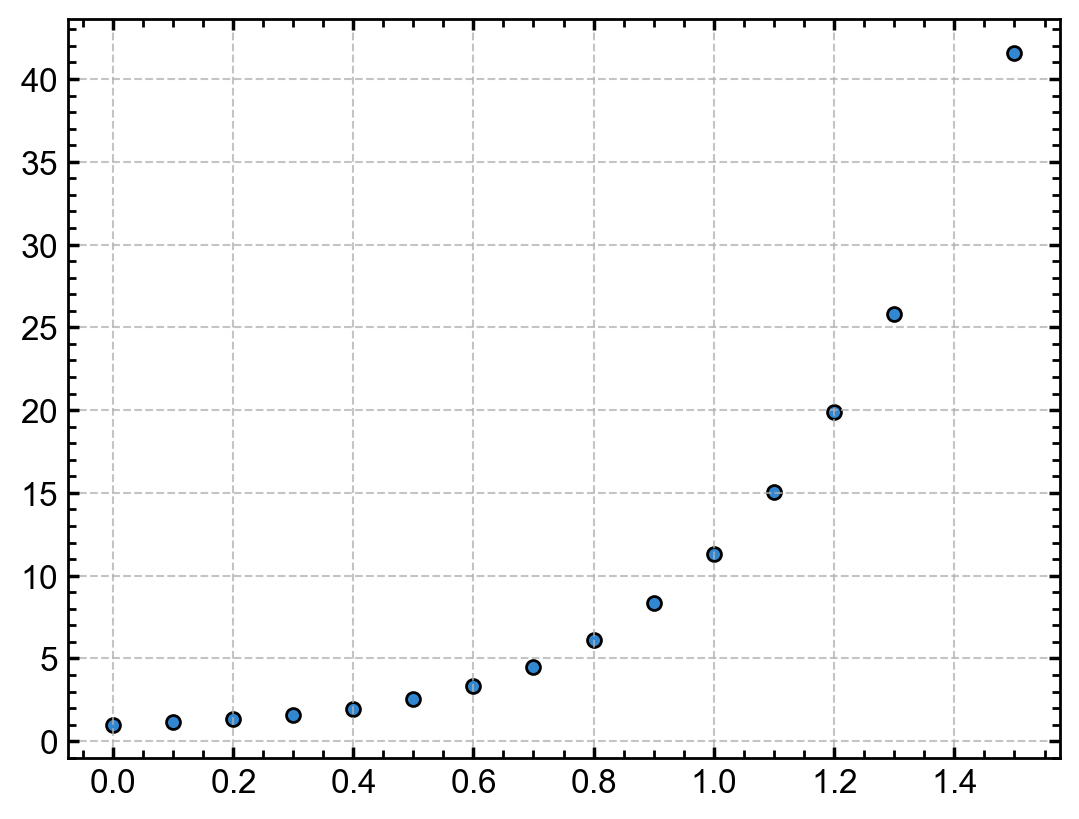

In [47]:
# tau_y = np.array(
#     [-0.00000000000000000001,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.5]
#     )

# normilized_fluxes = fluxes / fluxes[0]

plt.scatter(-taus, fluxes / fluxes[-1])

plt.show()

***

In [48]:
import pandas as pd

In [49]:
amp_df = pd.read_csv(
    "/Users/mike/Repos/iki/compps_simulations/data/results/tau_kTe_study_radiative_transfer_20260219_183753/results.csv"
)

amp_df

,kTe,tau_y,gamma,gamma_err_neg,gamma_err_pos,amplification_factor
0,100.0,-0.05,3.749166,0.003051,0.003060,1.062438
1,100.0,-0.10,3.282308,0.001734,0.001739,1.135109
2,100.0,-0.15,3.004871,0.001211,0.001213,1.220427
3,100.0,-0.20,2.819160,0.000562,0.000423,1.321433
4,100.0,-0.30,2.562038,0.000329,0.000329,1.586492
5,100.0,-0.40,2.378766,0.000250,0.000250,1.971370
6,100.0,-0.50,2.237717,0.000202,0.000202,2.533699
7,100.0,-0.60,2.124107,0.000170,0.000170,3.349489
8,100.0,-0.70,2.029642,0.000147,0.000147,4.513387
9,100.0,-0.80,1.949343,0.000169,0.000158,6.137221


(1, 40)

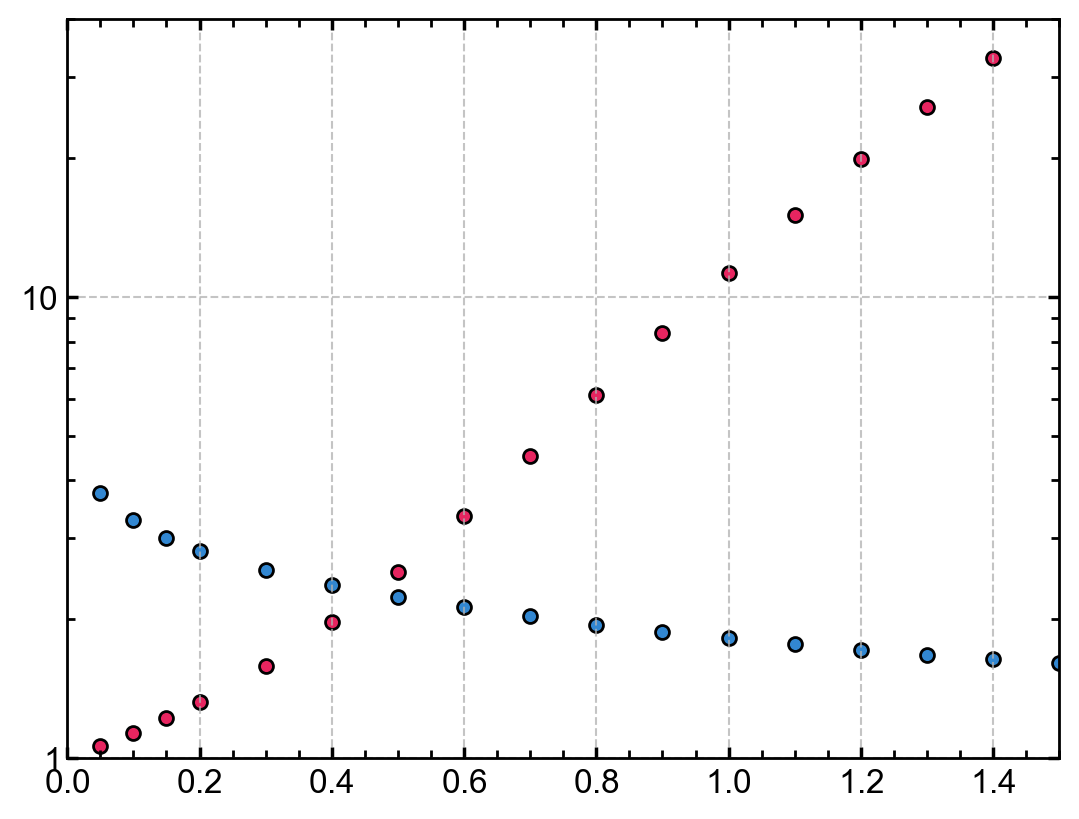

In [56]:
plt.scatter(-amp_df['tau_y'], amp_df['gamma'])

plt.scatter(-amp_df['tau_y'], amp_df['amplification_factor'])

plt.yscale('log')

plt.xlim(0, 1.5)
plt.ylim(1, 40)

In [71]:
from scipy.interpolate import CubicSpline

tau = -amp_df['tau_y']
gamma = amp_df['gamma']
amp = amp_df['amplification_factor']

In [72]:
cs_gamma = CubicSpline(tau, gamma)
tau_smooth = np.linspace(tau.min(), tau.max(), 300)
gamma_smooth = cs_gamma(tau_smooth)

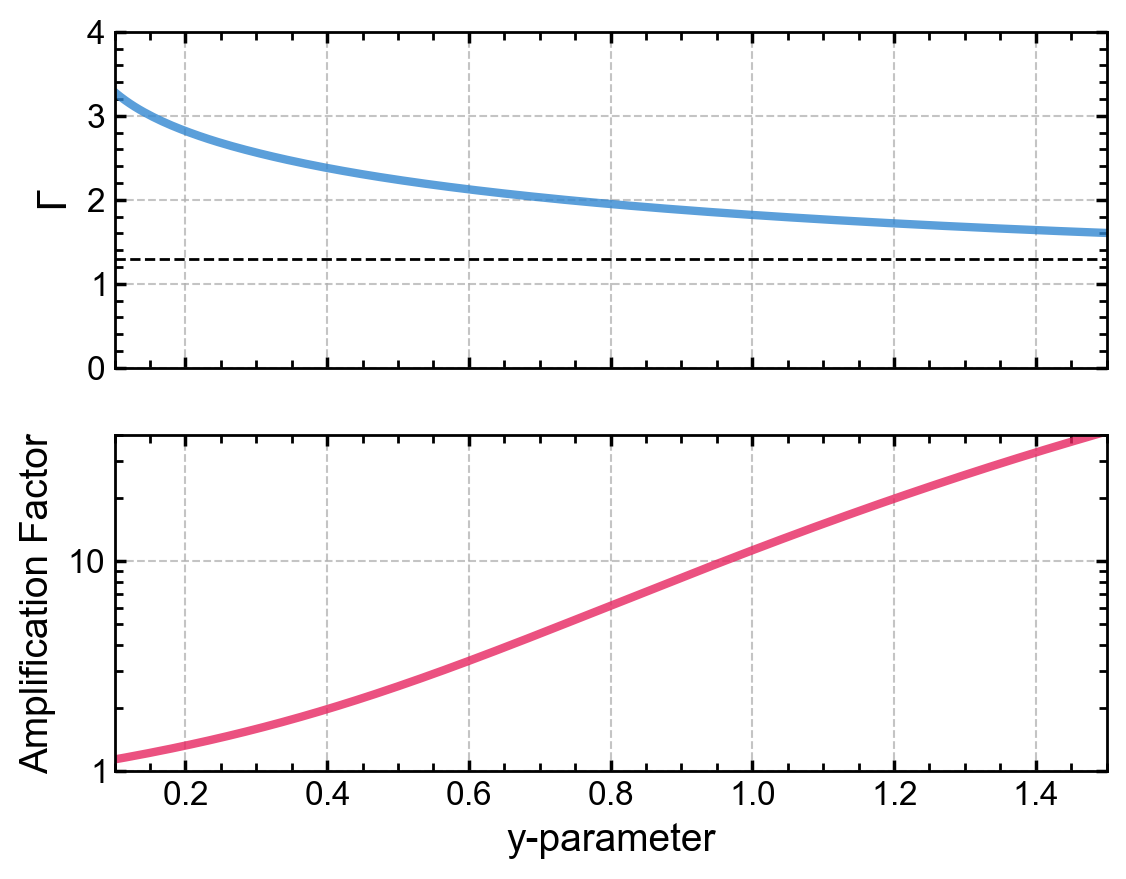

In [91]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# ax1.scatter(tau, gamma, color='C0')
ax1.plot(
    tau_smooth, gamma_smooth,
    marker=None,
    lw=3,
    alpha=0.8,
    color='C0'
)
ax1.set_xlim(0.1, 1.5)
ax1.set_ylabel(r'$\Gamma$')
ax1.axhline(1.3, ls='--', color='k')
ax1.set_ylim(0, 4)

cs_amp = CubicSpline(tau, amp)
tau_smooth = np.linspace(tau.min(), tau.max(), 300)
amp_smooth = cs_amp(tau_smooth)

# ax2.scatter(tau, amp, color='C1')
ax2.plot(
    tau_smooth, amp_smooth,
    marker=None,
    lw=3,
    alpha=0.8,
    color='C1'
)
ax1.set_xlim(0.1, 1.5)

ax2.set_yscale('log')
ax2.set_ylim(1, 40)
ax2.set_ylabel('Amplification Factor')

ax2.set_xlabel('y-parameter')

plt.show()